# Evaluate CRNN on real-world Speech Commands recordings

*Dataset path:*  
`/Users/petros/MSc Computer Science/EECS MSc Project 24-25/Approach_1/data/Speech_Commands_Dataset`

This notebook:
1. Gathers every `.wav` file under the folder (recursively).  
2. Converts each clip to **mono 16 kHz, 5 s**.  
3. Extracts a **64-bin log-mel spectrogram** → normalises exactly as in training.  
4. Runs the pretrained **CRNN** and de-normalises its three outputs → **RT60, DRR, C50**.  
5. Saves a CSV and prints a quick summary plot.

In [1]:
# ==== Imports ====
import os, glob, itertools, warnings, json, math
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ==== Paths ====
DATA_ROOT = "" # Dataset Folder Path
MODEL_WEIGHTS = ""   # Load Trained Model .pt Format

# ==== Audio / feature constants (match training) ====
SAMPLE_RATE   = 16_000
TARGET_SECS   = 5
TARGET_LEN    = SAMPLE_RATE * TARGET_SECS          # 80 000 samples
N_MELS        = 64
SPEC_EXPECT_T = 160                                # frames after hop=512 on 5 s

# Per-label normalisation (from training notebook)
LABEL_MEAN = np.array([1.5,  -100.0, -4.0])
LABEL_STD  = np.array([0.75,   10.0,  3.0])

### BUT Reverb Dataset

In [3]:
DATA_ROOT = "" # Dataset Folder Path

In [5]:
class CRNN(nn.Module):
    def __init__(self, n_mels=64, hidden_size=64, output_size=3):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25)
        )

        self.gru = nn.GRU(input_size=32 * (n_mels // 4),
                          hidden_size=hidden_size,
                          batch_first=True,
                          bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, h = self.gru(x)
        h_concat = torch.cat([h[0], h[1]], dim=1)
        return self.fc(h_concat)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model  = CRNN().to(device)
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=device))
model.eval()
print("✅  Model loaded on", device)

✅  Model loaded on mps


In [7]:
def load_wav(path, target_sr=SAMPLE_RATE):
    """Load, down-mix to mono, resample to target_sr."""
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
    return wav

def pad_or_trim(wav, target_len=TARGET_LEN):
    if len(wav) < target_len:
        return np.pad(wav, (0, target_len - len(wav)))
    return wav[:target_len]

def logmel_db(wav, sr=SAMPLE_RATE, n_mels=N_MELS):
    mel = librosa.feature.melspectrogram(
        y=wav, sr=sr, n_mels=n_mels
    )
    return librosa.power_to_db(mel, ref=np.max)

def normalise_spec(x):
    return (x - x.mean()) / (x.std() + 1e-8)

def fix_time_dim(x, expect_t=SPEC_EXPECT_T):
    """Pad or crop time axis to expected length."""
    if x.shape[1] < expect_t:
        pad = expect_t - x.shape[1]
        return np.pad(x, ((0,0), (0,pad)))
    return x[:, :expect_t]

In [9]:
wav_files = sorted(
    glob.glob(os.path.join(DATA_ROOT, "**", "*.wav"), recursive=True)
)
print(f"🧾  Found {len(wav_files):,} wav files")

🧾  Found 81,220 wav files


In [19]:
import random

# Set seed for reproducibility
random.seed(42)

# Recursively find all .wav files
all_files = sorted(
    glob.glob(os.path.join(DATA_ROOT, "**", "*.wav"), recursive=True)
)

# Sample a small subset
N = 50
wav_files = random.sample(all_files, N)
print(f"🎯 Testing on {N} randomly selected files out of {len(all_files)} total.")


🎯 Testing on 50 randomly selected files out of 105829 total.


In [11]:
results = []

for path in tqdm(wav_files):
    try:
        # 1) waveform ➜ mono16k 5s
        wav = pad_or_trim(load_wav(path))

        # 2) log-mel spec ➜ normalise ➜ fix time
        spec = fix_time_dim(normalise_spec(logmel_db(wav)))

        # 3) numpy ➜ torch ➜ model
        x = torch.tensor(spec, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).cpu().numpy().squeeze()

        # 4) de-normalise labels
        pred = pred * LABEL_STD + LABEL_MEAN

        results.append({
            "file": os.path.relpath(path, DATA_ROOT),
            "RT60": float(pred[0]),
            "DRR":  float(pred[1]),
            "C50":  float(pred[2]),
        })
    except Exception as e:
        print("❌", path, e)

df = pd.DataFrame(results)
print("✅  Finished inference on", len(df), "files")

100%|███████████████████████████████████| 81220/81220 [1:09:54<00:00, 19.36it/s]

✅  Finished inference on 81220 files


📄  Saved predictions to speech_commands_real_predictions.csv


,file,RT60,DRR,C50
0,backward/0165e0e8_nohash_0.wav,0.218659,-11.533022,3.235110
1,backward/017c4098_nohash_0.wav,0.444970,-2.862034,12.507489
2,backward/017c4098_nohash_1.wav,0.365949,0.489120,16.987470
3,backward/017c4098_nohash_2.wav,0.586097,-4.535971,10.591297
4,backward/017c4098_nohash_3.wav,0.330685,4.195175,17.013759


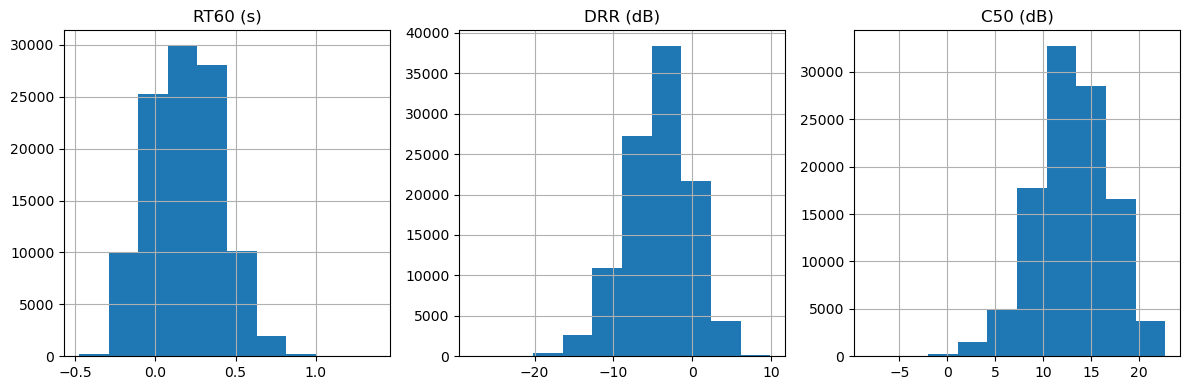

In [29]:
csv_out = "speech_commands_real_predictions.csv"
df.to_csv(csv_out, index=False)
print("📄  Saved predictions to", csv_out)

display(df.head())

# Quick distribution plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); df["RT60"].hist(); plt.title("RT60 (s)")
plt.subplot(1,3,2); df["DRR"].hist();  plt.title("DRR (dB)")
plt.subplot(1,3,3); df["C50"].hist();  plt.title("C50 (dB)")
plt.tight_layout(); plt.show()

📄  Saved predictions to VUT_FIT_Q301_predictions.csv


,file,RT60,DRR,C50
0,MicID01/SpkID01_20170910_T/01/english/LibriSpe...,0.562744,-0.663958,10.819309
1,MicID01/SpkID01_20170910_T/01/english/LibriSpe...,0.873369,-3.321323,7.682154
2,MicID01/SpkID01_20170910_T/01/english/LibriSpe...,0.783726,0.891724,7.842788
3,MicID01/SpkID01_20170910_T/01/english/LibriSpe...,0.754932,-7.550230,4.143937
4,MicID01/SpkID01_20170910_T/01/english/LibriSpe...,0.704523,1.188526,9.027688


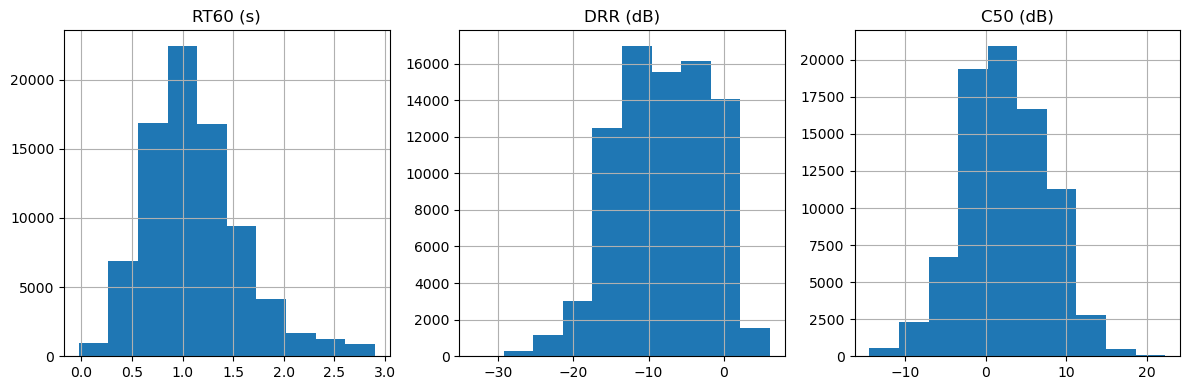

In [13]:
csv_out = "VUT_FIT_Q301_predictions.csv"
df.to_csv(csv_out, index=False)
print("📄  Saved predictions to", csv_out)

display(df.head())

# Quick distribution plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); df["RT60"].hist(); plt.title("RT60 (s)")
plt.subplot(1,3,2); df["DRR"].hist();  plt.title("DRR (dB)")
plt.subplot(1,3,3); df["C50"].hist();  plt.title("C50 (dB)")
plt.tight_layout(); plt.show()